# *BBC News Topic Modeling & Classification*
_Samuel Ghalayini_
## Introduction  
In this notebook I explore non-negative matrix factorization to see how well it can predict one of five fields the article was written about. This notebook walks through exploratory data analysis, text preprocessing, feature engineering (TF-IDF), hyperparameter tuning, and both unsupervised (NMF) and supervised (Logistic Regression) classification pipelines. For the unsupervised approach I've implemented a model that predicts off of a non-negative matrix facctorization that achieved an accuracy score of 0.9250. For the supervised approach I've implemented a logistic regression model that achieved an accuracy score of 0.9583.

## Objectives  
- **Extracting word features and show Exploratory Data Analysis (EDA)**: Inspect, visualize and clean the data. Process text to matrix form(word embedding) 
- **Building and training models**: Apply the matrix factorization method to discover topics in the news articles and use the labels to chekc the accuracy
- **Compare with supervised learning**: Comparison of the supervised and unsupervised approaches

In [32]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


## Exploratory Data Analysis (EDA) 
Our dataset is split between 1490 training articles and 735 test articles. There are no missing values but 100 duplicate articles (mostly tech). Tech and political articles tend to be longer and above 400 words per article on average where the rest average around 325 words per article. Next I look at the uniqueness of an article as a ratio of all words in the article (Type-Token Ratio). This can tell us how diverse an article is and you can see from Figure 3, the violin plots that tech and political articles are less lexically diverse than the others. This could be connected to why those two categories are also longer.

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
Training data shape: (1490, 3)
Testing data shape: (735, 2)
Dtypes:
 ArticleId     int64
Text         object
Category     object
dtype: object
Missing values:
 ArticleId    0
Text         0
Category     0
dtype: int64


<Figure size 600x400 with 0 Axes>

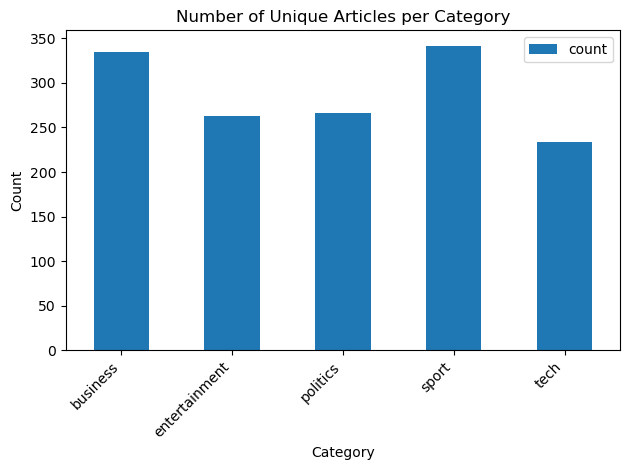

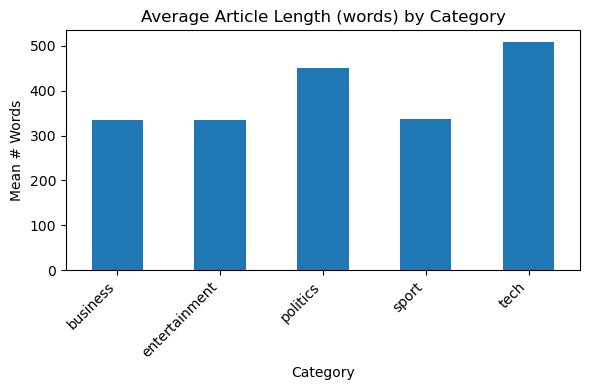

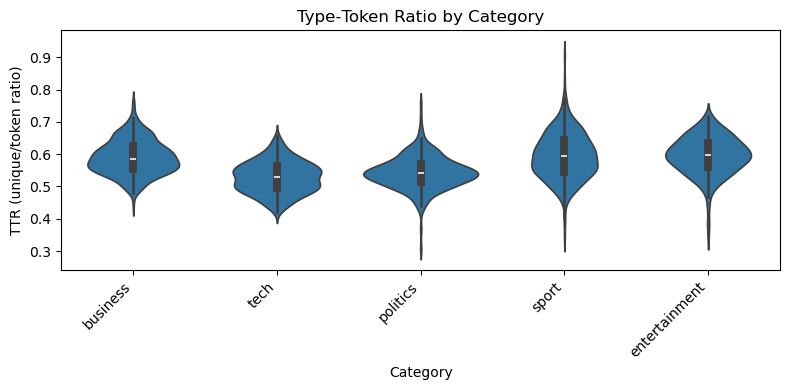

In [33]:
# loading our train and test data
train_data = pd.read_csv("BBC News Train.csv")
test_data  = pd.read_csv("BBC News Test.csv")

# looking at our data values, shape, and if there are any missing values
print(train_data.head(3))
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("Dtypes:\n", train_data.dtypes)
print("Missing values:\n", train_data.isnull().sum())

# drop duplicates
train_data = train_data.drop_duplicates(subset=['Text'], keep='first')
counts = train_data['Category'].value_counts().sort_index()
counts = counts.reset_index().rename(columns={'index':'Category', 'Category':'Count'})
plt.figure(figsize=(6,4))
counts.set_index('Count').plot(kind='bar')
plt.title("Number of Unique Articles per Category")
plt.ylabel("Count")
plt.xlabel("Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plot the average article length by words
train_data['word_count'] = train_data['Text'].str.split().apply(len)
avg_lengths = train_data.groupby('Category')['word_count'].mean().sort_index()
plt.figure(figsize=(6,4))
avg_lengths.plot(kind='bar')
plt.title("Average Article Length (words) by Category")
plt.ylabel("Mean # Words")
plt.xlabel("Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plot the word ubniqueness percentage or type token ratio
train_data['vocab_size'] = train_data['Text'].apply(lambda i: len(set(i.split())))
train_data['ttr'] = train_data['vocab_size'] / train_data['word_count']
plt.figure(figsize=(8,4))
sns.violinplot(data=train_data, x='Category', y='ttr', inner='box')
plt.title("Type‑Token Ratio by Category")
plt.ylabel("TTR (unique/token ratio)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Lexical Diversity and Visualizations
We lowercase text, strip punctuation, and remove English stop-words (e.g. “the”, “said”, “s”) to focus on substantive terms. I removed the stop words because the goal of this project was to fit an unsupervised model to the topics between each article and not for the tone or readability of the articles. Because we are looking at topics and substance rather than structure I removed common words like "said, "the", "a" from the articles. To further clean the article I've implemented a stemmer. A stemmer is a tool that joins words that have a common form. This includes removing suffixes and grouping "running", "runs", "ran" into one work "run". This way I can further narrow down how each category is separated by topic. The two stemmers I tried out were called PorterStemmer and SnowballStemmer. I've decided to implement Snowball stemmer for its balanced aggression of stemming words too much and losing topics while also stemming words that are common. Looking at common phrases (trigrams) or common words in each category showed me how common and uninformative the stop words were. The word clouds also showed the importance of stemming to distill information. At first the word clouds contained just common english words but now you notice topics that relate to the category such as "firm" and "economic" for business.

Length of a raw article: 1866
Length of filtered text article: 1350
Length of stemmed text article: 1160


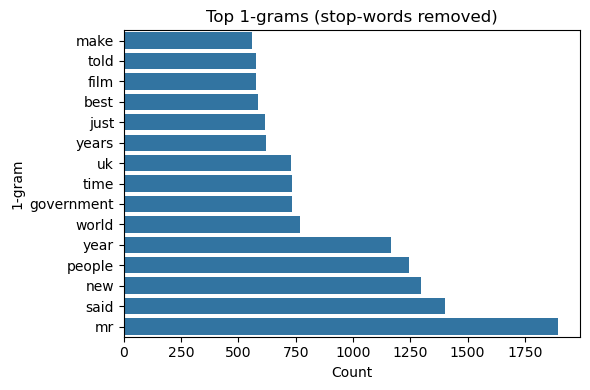

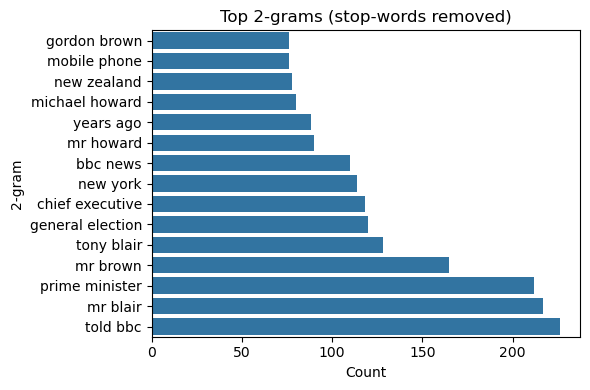

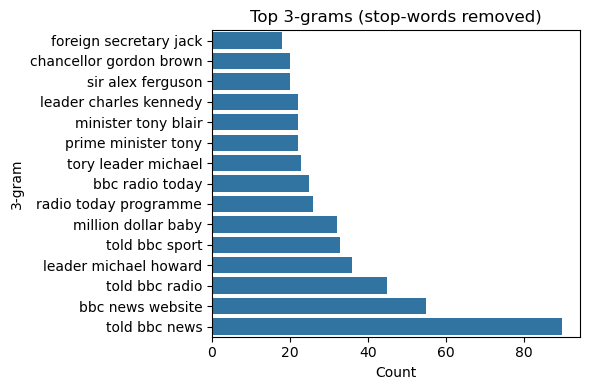

In [34]:

# remove stop words and 'said' and 's' from articles, put all words into lowercase
custom_stops = ENGLISH_STOP_WORDS.union({'said', 's'})
train_data['Text_filtered'] = train_data['Text'].str.lower().str.split().apply(lambda toks: [w for w in toks if w not in custom_stops]).str.join(' ')

# remove puncuation and empty strings
table = str.maketrans('', '', string.punctuation)
train_data['Text_filtered'] = train_data['Text_filtered'].apply(lambda txt: txt.translate(table))

# stemming, talk about why I picked snowmball stemmer over porter stemmer
ss = SnowballStemmer("english")
train_data['Text_stemmed'] = train_data['Text_filtered'].str.split().apply(lambda toks: [ss.stem(w) for w in toks]).str.join(' ')

print("Length of a raw article: {}\nLength of filtered text article: {}\nLength of stemmed text article: {}".format(len(train_data.Text[0]), len(train_data.Text_filtered[0]), len(train_data.Text_stemmed[0])))


# unigrams, bigrams, trigrams on filtered text
for n in [1, 2, 3]:
    vec = CountVectorizer(ngram_range=(n, n), max_features=15)
    X = vec.fit_transform(train_data['Text_filtered'])
    counts = X.sum(axis=0).A1
    terms  = vec.get_feature_names_out()
    df_ngrams = pd.DataFrame({'ngram': terms, 'count': counts}).sort_values('count')
    
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_ngrams, x='count', y='ngram')
    plt.title("Top {}-grams (stop‑words removed)".format(n))
    plt.xlabel("Count")
    plt.ylabel("{}-gram".format(n))
    plt.tight_layout()
    plt.show() 
    

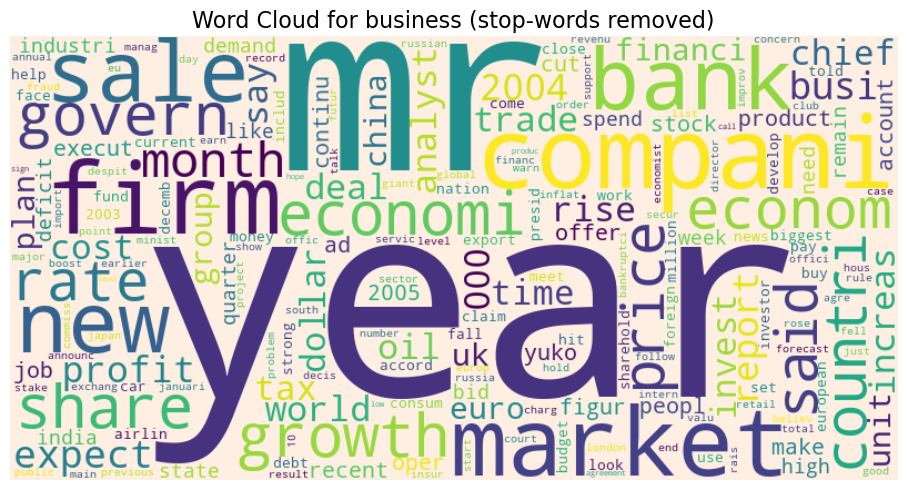

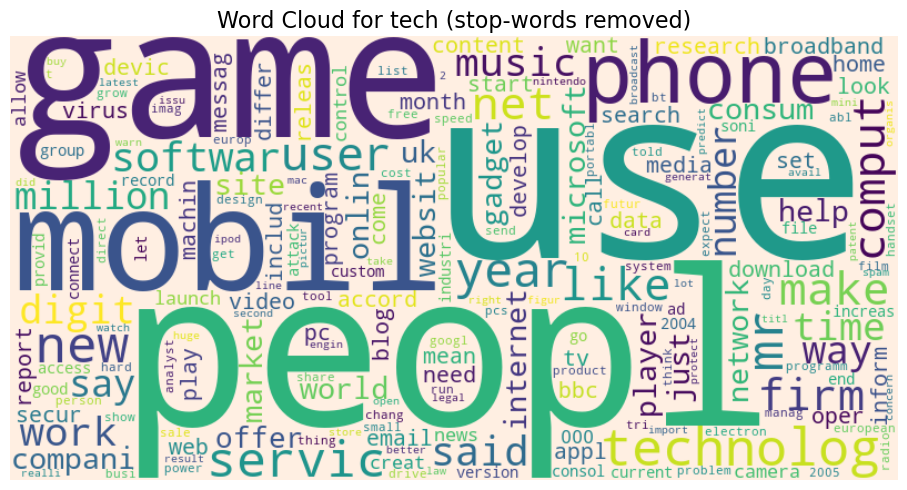

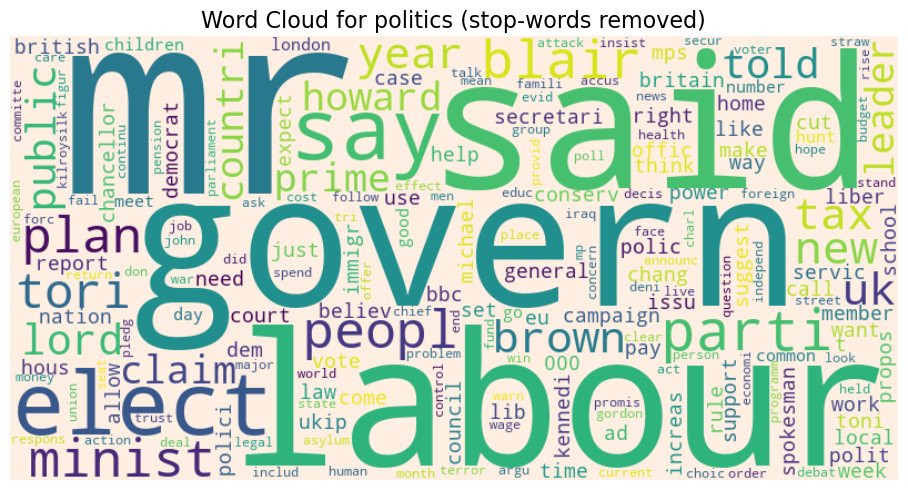

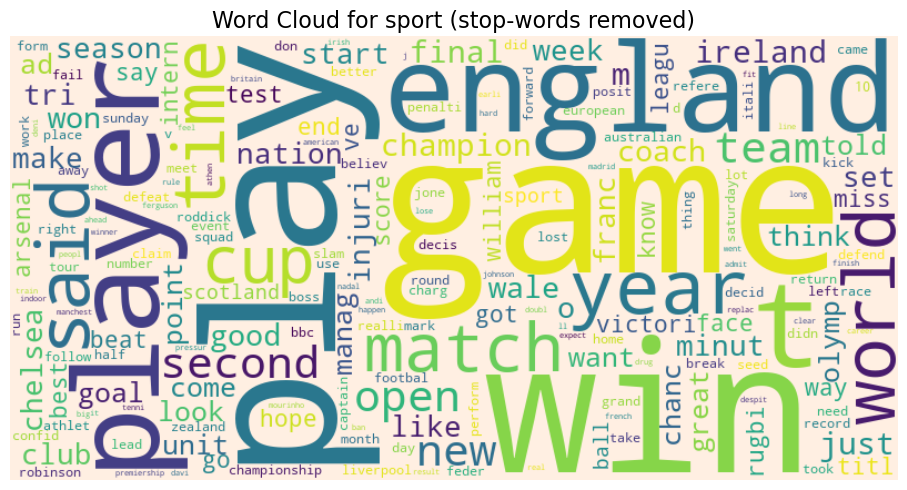

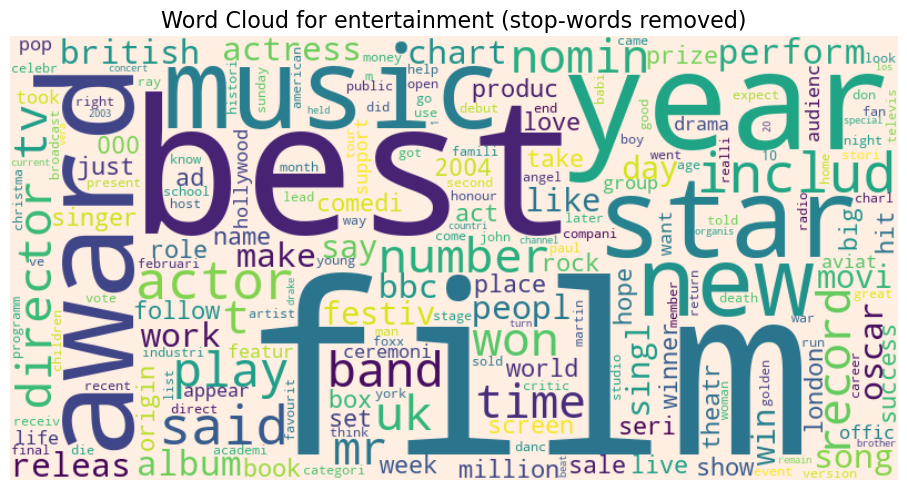

In [35]:
for cat in train_data['Category'].unique():
    words = train_data.loc[train_data['Category'] == cat, 'Text_stemmed'].str.split().explode()
    freqs = words.value_counts().to_dict()
    wc = WordCloud(width=800, height=400, background_color= (255, 239, 226)).generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {cat} (stop‑words removed)", fontsize=16)
    plt.tight_layout()
    plt.show()


## Feature Engineering  
First, we need to transform our raw text into feature vectors that can be fed into Non-Negative Matrix Factorization (NMF). The model requires a numeric matrix as input, as strings don’t accurately represent the importance of each word in a single article or the importance of words across our entire dataset. The rubric provided several word embeddings for us to choose from, and I chose TF-IDF (Term Frequency * Inverse Document Frequency) because it’s more suitable for handling smaller datasets. TF-IDF was easy to interpret and resulted in a matrix that didn’t overcomplicate the process. I found a helpful graph that I recreated from the Kaggle Project outline: a t-SNE projection of TF-IDF vectorization. The t-distributed stochastic neighbor embedding technique proved invaluable for visualizing the high dimensions of the TF-IDF vectors and compressing them into a 2D graph. tSNE considers the similarity of each vector and maps out their distances from the high-dimensional word embedding to a 2D space. I found this visualization particularly effective because it demonstrated the differences in distance between the categories while preserving crucial information in the dimensionality reduction.

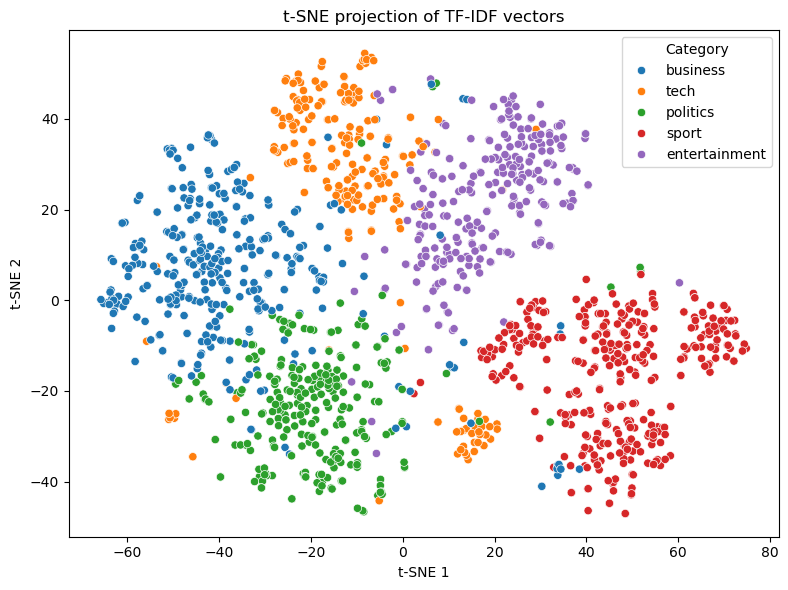

In [36]:
# tidf for word embedding, turn strings into numerics
tfidf = TfidfVectorizer(norm='l2')
X = tfidf.fit_transform(train_data['Text_stemmed']).toarray()
y = train_data['Category']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot( x=X2[:,0], y=X2[:,1], hue=train_data['Category'])
plt.title("t‑SNE projection of TF‑IDF vectors")
plt.xlabel("t‑SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


## 7. Unsupervised Modeling  
### 7.1 NMF-Based Clustering  
Our unsupervised learning model leverages Non-Negative Matrix Factorization to predict article categories through majority voting. The confusion matrix reveals that entertainment articles were frequently misclassified as tech, while business articles were misclassified as politics.

Figure 1 shows how accuracy fluctuates with the NMF rank, while Figure 2 presents accuracy in relation to the TF-IDF vocabulary size. A rank of 5 categories and the largest TF-IDF vocabulary resulted in the highest accuracy. I experimented with various normalization functions in the TF-IDF and opted for L2 normalization. Additionally, expanding the range of words included in my TF-IDF, allowing up to 3-gram sequences, significantly improved accuracy by 0.020 to 0.9250.

Best Accuracy: 0.925


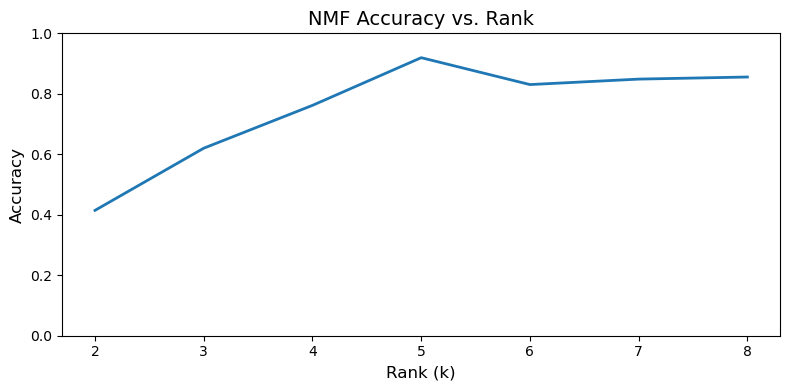

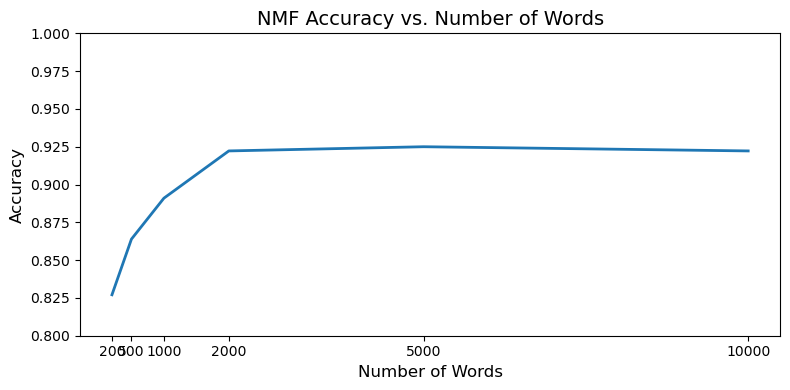

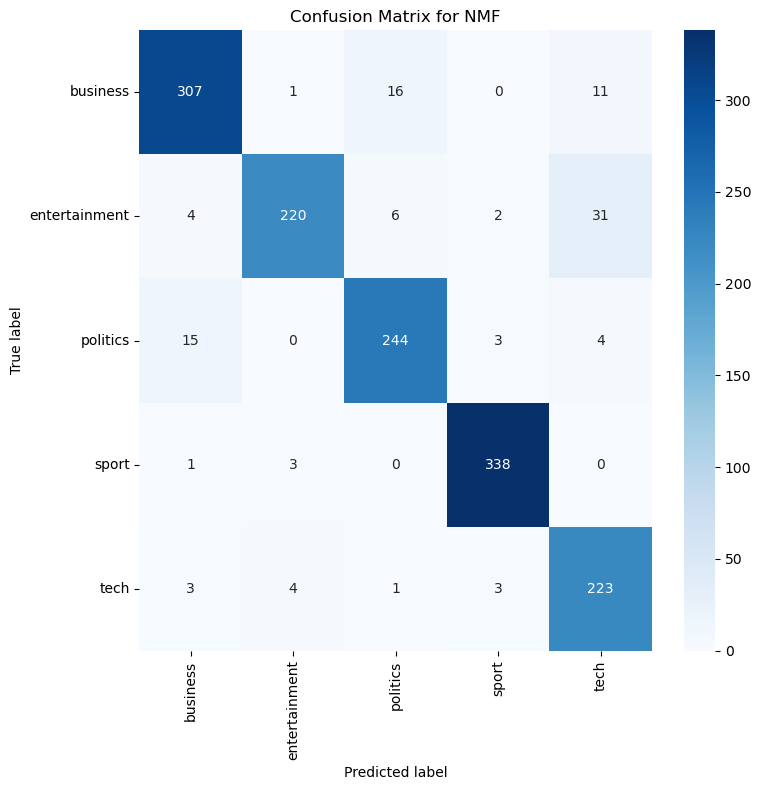

In [37]:
results = []
ranks = [2, 3, 4, 5, 6, 7, 8]
num_words = [200, 500, 1000, 2000, 5000, 10000]
max_acc = 0
# rank
for rank in ranks: # 5 is probably the best number of categories because there are given 5 distinct categories
    nmf = NMF(n_components=rank)
    W = nmf.fit_transform(X)
    pred_cat = np.argmax(W, axis=1)
    
    category = {}
    for i in range(rank): # map articles to numeric category
        mask = pred_cat == i
        category[i] = y[mask].mode()[0]
        
    y_pred = [category[i] for i in pred_cat]
    acc = accuracy_score(y, y_pred)
    results.append(acc)
# num words
w_results = []
for max_words in num_words:
    tfidf = TfidfVectorizer(max_features=max_words, norm='l2', ngram_range=(1,3))
    X = tfidf.fit_transform(train_data['Text_stemmed']).toarray()
    nmf = NMF(n_components=5)
    W = nmf.fit_transform(X)
    pred_cat = np.argmax(W, axis=1)
    category = {}
    for i in range(5):
        mask = pred_cat == i
        category[i] = y[mask].mode()[0]
        
    y_pred = [category[i] for i in pred_cat]
    acc = accuracy_score(y, y_pred)
    w_results.append(acc)
    if acc > max_acc:
        max_acc = acc
        y_best = y_pred
# confusion matrix
print("Best Accuracy: {}".format(max(w_results)))
labels = np.unique(y)
cm = confusion_matrix(y, y_best, labels=labels)
df_num_words = pd.DataFrame({'Number of Words': num_words, 'Accuracy': w_results})
df_acc = pd.DataFrame({'Rank': ranks, 'Accuracy': results})
# Rank Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_acc,x='Rank', y='Accuracy', linewidth=2)
plt.title("NMF Accuracy vs. Rank", fontsize=14)
plt.xlabel("Rank (k)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(ranks)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
# Num_words Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_num_words,x='Number of Words', y='Accuracy', linewidth=2)
plt.title("NMF Accuracy vs. Number of Words", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(num_words)
plt.ylim(0.8,1)
plt.tight_layout()
plt.show()
# Confusion Matrix Plot
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix for NMF")
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.tight_layout()
plt.show()


## 8. Supervised Modeling  
### 8.1 Logistic Regression on TF-IDF 
After exploring classification using an unsupervised approach, we proceed to evaluate a supervised model. I implemented a logistic regression model using the TF-IDF vectors calculated from our stemmed articles. The model was trained on 10%, 20%, 50%, and 100% of the labeled data, with a 20% hold-out of our original training data used for validation. The validation accuracy improved from .8229 to .9583.
| Fraction | Train Accuracy | Test Accuracy |
|:--------:|:---------:|:--------:|
| 10 %     | 1.0000    | 0.8229   |
| 20 %     | 1.0000    | 0.8993   |
| 50 %     | 0.9983    | 0.9375   |
| 100 %    | 0.9965    | 0.9583   |


In [38]:
# Logistic Regression training and hold out fractions of the data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

fractions = [0.1, 0.2, 0.5, 1]
results = []
for frac in fractions:
    if frac < 1.0:
        X_train, x_t, y_train, y_t = train_test_split(
            X_train_full, y_train_full,
            train_size=frac,
            stratify=y_train_full,
            random_state=42)
    else:
        X_train, y_train = X_train_full, y_train_full

    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc   = accuracy_score(y_test, clf.predict(X_test))

    results.append((int(frac*100),train_acc,test_acc, clf.predict(X_test)))
print("Logistic Regression Accuracy")
for i in results:
    print("Fraction of data: {}, Training Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(i[0], i[1], i[2]))

Logistic Regression Accuracy
Fraction of data: 10, Training Accuracy: 1.0000, Test Accuracy: 0.8229
Fraction of data: 20, Training Accuracy: 1.0000, Test Accuracy: 0.8993
Fraction of data: 50, Training Accuracy: 0.9983, Test Accuracy: 0.9375
Fraction of data: 100, Training Accuracy: 0.9965, Test Accuracy: 0.9583


## References  
- https://www.kaggle.com/c/learn-ai-bbc/overview
- https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://nlp.stanford.edu/projects/glove/
- https://radimrehurek.com/gensim/models/word2vec.html
- https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw  